# Image Un-tessellation using GAMS

This is a simple problem. Say we have a picture, represented as a two-dimensional array of numbers (pixel values), and we chop this image up into small pieces, much like a jigsaw puzzle. This corresponds to a *tessellation* of the image. The question addressed in this work is: can we put the pieces back together to recover the original image? And if so, how?

*Note*: the original goal of this project was indeed to solve jigsaw puzzles, but I shelved that goal for now because coding the data for that setting is a little more complicated than I imagined.

### A short summary of what follows

In this notebook we'll see two ways of approaching this problem:
- Assume we have a *guide image* to which we can try to align all our pieces. In that case we can define a cost function $D(p,i,j)$ for a patch $p$ placed at a location $(i,j)$, using the corresponding pixels of the guide image at that location. This results in the formulation of a simple assignment problem to minimize $D$, which has a total unimodular (TU) network structure. We can solve it using just a linear programming (LP) solver since the solutions to such problems are already integral.

    We will study the performance of this solution as we degrade the resolution of our guide image, which will show that the difficulty of this problem increases substantially if our guide image is not accurate. The solutions in those cases will have perceptible "blocky" artifacts.


- Assume we have no external information, and just try to put pieces together such that their edges are as continuous as possible, that is to say that the pixel values should not vary too much as we move from a piece to its another one adjacent to it. This gives us a cost function based on the sum of absolute differences between the pixel values of adjacent pieces (after placement). This formulation does not have the TU property, so we have to use a mixed-integer programming (MIP) solver for this version of the solution.

    This solution is substantially slower than the previous one, and is intractable for puzzles with hundreds of pieces. The code here only shows an example with $3 \times 4 = 12$ pieces.

To get the best of both worlds, we could try a mix of the above two approaches: use an approximate (low-resolution) guide image to get close to the right configuration of pieces, and use the second method to shift pieces within only a small neighborhood such that they align better. This way, we could still solve this kind of problem well even if our data were of low quality. Unfortunately, I couldn't try this combination in time for the deadline.

## Example of problem

The next block constructs an instance of the un-tessellation problem. We do not allow the pieces to be rotated.

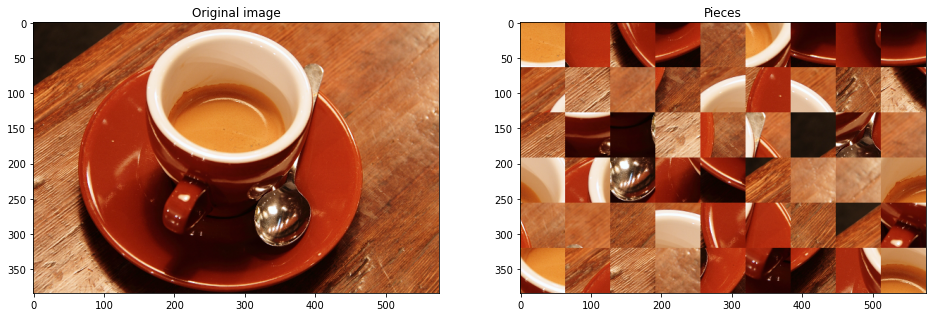

In [1]:
from skimage import data as skimdata
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import img_as_float

RNG_SEED = 27
RNG = np.random.default_rng(RNG_SEED)

img = img_as_float(getattr(skimdata, 'coffee')())
psize = 64 # piece size

# helper function
from misc import center_crop
# make image size a multiple of psize through cropping
img = center_crop(img, psize)
H, W = img.shape[:2]
Hp, Wp = H // psize, W // psize

def make_pieces_norotate(img, psize, shuffle=False):
    pieces = np.array([img[ip*psize:(ip+1)*psize, jp*psize:(jp+1)*psize, ...]
                       for ip in range(Hp)
                       for jp in range(Wp)],
                      dtype=img.dtype)
    if shuffle:
        # shuffle the pieces to mix them up
        RNG.shuffle(pieces, axis=0)
    return pieces

pieces = make_pieces_norotate(img, psize, shuffle=True)

# more helper functions
from misc import rect_layout, show_sidebyside
show_sidebyside(img, rect_layout(pieces, Hp, Wp), right_title='Pieces')

## Version 1: with guide image

In addition to the pieces shown above, let's also assume that we have **complete access to the true image we are trying to construct**, so our only goal is to place the pieces in a way that they coincide exactly with the ground truth. This is not always a realistic assumption (though I'd like to note that we do usually get a complete image accompanying a jigsaw puzzle), but it results in a simple formulation, and helps get the ball rolling.

Further, in real jigsaw puzzles the shapes provide strong guidance to a (human) solver, with a distinctive, readily perceptible feedback when the piece has been placed correctly. We haven't encoded shape-based information in our problem yet, so I don't feel so bad about lending the solver a hand...

### Solution approach

With the assumption on having the ground truth image (termed the *guide image* $g[m,n]$ from here on), the problem can be treated as an *assignment problem*, where we try to match patches to their possible locations. For a given piece, we can measure its fit to a particular candidate location by measuring the sum-of-squared differences between the pixel values of the piece and those of the guide image at the candidate location. We define this measure of fit as $D$:

\begin{equation}
    D(p, (i_0, j_0)) = \sum_{m,n} \left( p[m,n] - g[i_0 + m, j_0 + n] \right)^2
\end{equation}

where $p$ denotes a piece taken from a whole set of pieces $\mathbb{P}$, and $(i_0, j_0)$ represent a particular offset from the image origin at which we are trying to place $p$.

In [2]:
def compute_fit(pieces, img):
    # compute fit measure
    def _msd(a, b):
        return np.mean((a - b) ** 2)

    N, psize = pieces.shape[:2]
    H, W = img.shape[:2]
    Hp, Wp = H // psize, W // psize
    D = np.empty((N,Hp,Wp), dtype=np.double)
    for p in range(N):
        for i in range(Hp):
            for j in range(Wp):
                D[p,i,j] = _msd(img[i*psize:(i+1)*psize, j*psize:(j+1)*psize,...],
                                pieces[p,:,:,...])
    return D

D = compute_fit(pieces, img)

Having computed $D$, we can model the assignment problem as a *Min-Cost Network Flow* (MCNF) problem with a bipartite graph. This graph comprises of the set of pieces (previously denoted by $\mathbb{P}$), and the set of possible candidate locations $\mathbb{I} \times \mathbb{J}$, where $\mathbb{I} := \{1, 2, 3, \ldots, H_p\}$ and $\mathbb{J} := \{1, 2, 3, \ldots, W_p\}$ are the possible row and column offsets at which we can place the pieces. $H_p$ and $W_p$ can be calculated from the guide image as shown in the code above. Naturally, $|\mathbb{P}| = H_p W_p$. 

We define a variable $x(p,i,j)$, which takes the value 1 when the piece $p$ is placed at the offset $(i, j)$, and 0 otherwise. A piece can take only one location, and a location can only be filled by one piece.

The edge weight between a piece $p \in \mathbb{P}$ and a candidate location $(i, j) \in \mathbb{I} \times \mathbb{J}$ is given by $D(p, (i,j))$ as defined above. Our final MCNF problem formulation is therefore:

\begin{align}
    \min \sum_{p,i,j} x(p, i, j) \cdot D(p, i, j), & \, \mbox{such that}\\
    \forall (i, j) \in \mathbb{I} \times \mathbb{J},
        \sum_p x(p, i, j) & = 1 \\
    \forall p \in \mathbb{P},
        \sum_{i,j} x(p, i, j) & = 1
\end{align}

This network matrix has total unimodularity as discussed in the class lectures, and can therefore be solved efficiently using just the network simplex method in the CPLEX linear programming (LP) solver. We don't need a mixed-integer programming (MIP) solver here even though our desired solution has to be integer.

In [3]:
# GAMS setup
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

# remove cplex.opt file (optional); gams_cleanup doesn't remove it
import os
if os.path.exists('cplex.opt'):
    os.remove('cplex.opt')

In [4]:
%%gams
option lp = cplex;
option threads = 4;
$onecho > cplex.opt
lpmethod 3
$offecho

sets
    piece_idxs(*),
    row_idxs(*),
    col_idxs(*);
parameters
    D(piece_idxs<, row_idxs<, col_idxs<);

In [5]:
# send computed fit measure to GAMS
%gams_push D

In [6]:
%%gams
alias (piece_idxs, P);
alias (row_idxs, I);
alias (col_idxs, J);

* no need to be binary
positive variables x(P,I,J);
free variable z;

equations
    one_piece_one_place(P),
    one_place_one_piece(I,J),
    obj_eval_D;

obj_eval_D..
    z =e= sum((P,I,J), x(P,I,J) * D(P,I,J));

one_piece_one_place(P)..
    sum((I,J), x(P,I,J)) =e= 1;

one_place_one_piece(I,J)..
    sum(P, x(P,I,J)) =e= 1;

model puzzle
    /
        one_piece_one_place,
        one_place_one_piece,
        obj_eval_D
    /;

In [7]:
%gams solve puzzle using lp minimizing z;

Solver Status        Model Status  Objective #equ  #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)        0.0  109  2917         LP  CPLEX   

  Solver Time  
0       0.033

The solver returns with an objective value of zero. That means it should have been able to place the pieces correctly. Let's check out the solution to make sure it did.

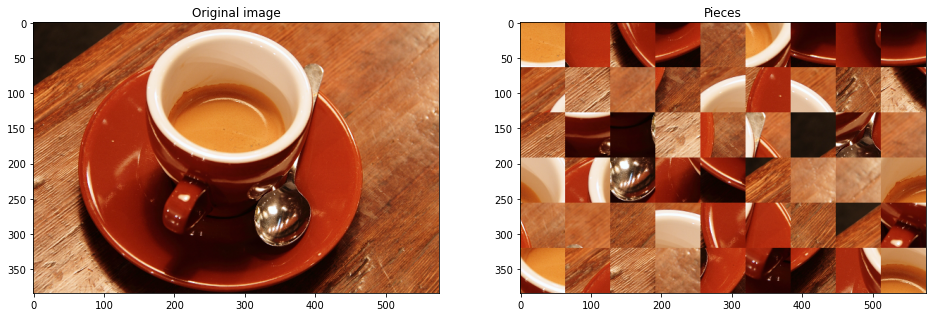

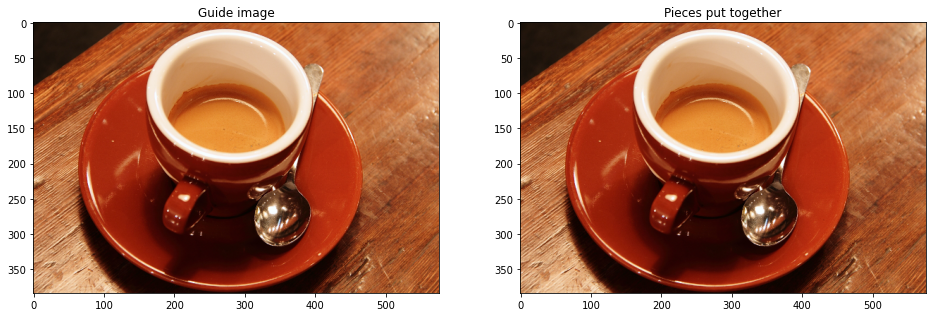

In [8]:
%gams_pull -d x

# only need the non-zero xs
x = x[x['level'] > 0]

# Take the piece idx, row_idx, and col_idx
# (first 3 columns).
# GAMS uses 1-indexing, Python uses 0-
# and we want ints now
x = x.iloc[:,:3].astype(int) - 1

def put_pieces_together(pieces, Hp, Wp, assign=None):
    psize = pieces.shape[1]
    if len(pieces.shape) > 3:
        C = pieces.shape[3]
        out = np.empty((Hp*psize, Wp*psize, C), dtype=pieces.dtype)
    else:
        out = np.empty((Hp*psize, Wp*psize), dtype=pieces.dtype)
    if assign is not None:
        assign = assign.sort_values('piece_idxs')
    for p in range(pieces.shape[0]):
        piece = pieces[p,...]
        if assign is None:
            i = p // Wp
            j = p % Wp
        else:
            i = assign.iloc[p,1]
            j = assign.iloc[p,2]
        out[i*psize:(i+1)*psize, j*psize:(j+1)*psize,...] = piece
    return out

sol = put_pieces_together(pieces, Hp, Wp, assign=x)

# 1st side-by-side plot shows an arbitrary arrangement of the pieces
show_sidebyside(img, rect_layout(pieces, Hp, Wp), right_title='Pieces')
# 2nd one shows the one obtained by the solver 
show_sidebyside(img, sol, left_title='Guide image')

Hurray! The solver worked. At least we were able to solve the simplest case, as we'd expect.

### Varying problem size

We can try this method on a different size of problem (varying the size of the pieces).

In [9]:
psize = 16
Hp, Wp = H // psize, W // psize
pieces = make_pieces_norotate(img, psize, shuffle=True)
D = compute_fit(pieces, img)

%gams_push D
%gams solve puzzle using lp minimizing z;

Solver Status        Model Status  Objective  #equ    #var Model Type  \
0    Normal (1)  Optimal Global (1)        0.0  1729  746497         LP   

  Solver Solver Time  
0  CPLEX       4.388

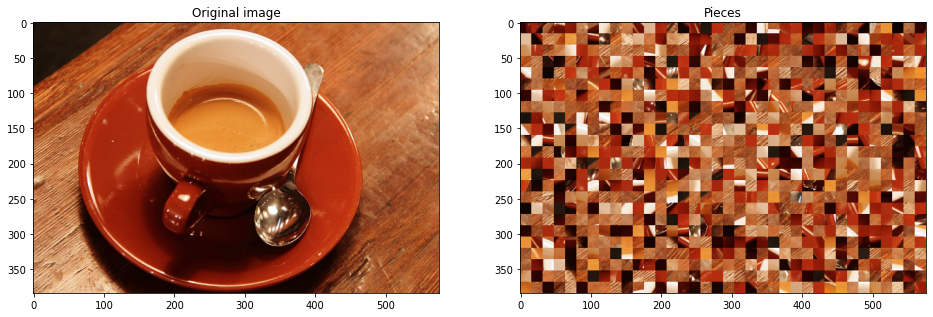

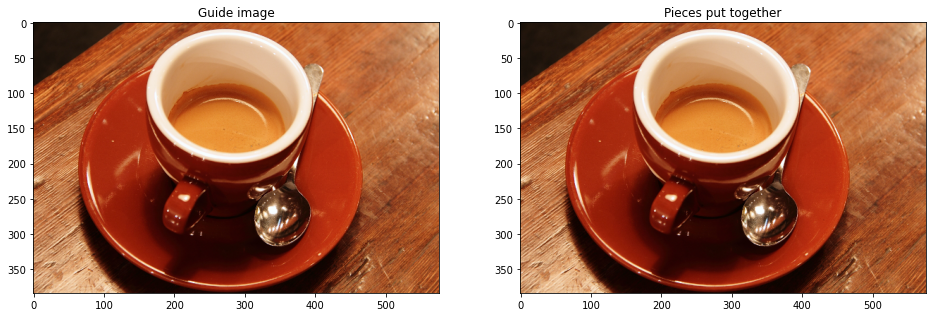

In [10]:
%gams_pull -d x
# only need the non-zero xs
x = x[x['level'] > 0]
# GAMS uses 1-indexing, Python uses 0-
# and we want ints now
x = x.iloc[:,:3].astype(int) - 1
sol = put_pieces_together(pieces, Hp, Wp, assign=x)
show_sidebyside(img, rect_layout(pieces, Hp, Wp), right_title='Pieces')
show_sidebyside(img, sol, left_title='Guide image')

We can see that we can still solve the problem, but it takes a lot longer now. On examining the solver output, it's clear that the problem size increases a lot as we make the pieces smaller. The bipartite network in this assignment problem is densely connected (all pieces can theoretically be placed anywhere), which means the number of arcs (equal to the number of $x$s) is the square of the number of pieces, and thus grows very fast. 

One way to help the situation is to remove the arcs corresponding to very high values of $D(p, i, j)$, because they can't possibly be the right combination. Equivalently, we could keep the $k$ lowest values of $D(p, i, j)$, for some value of $k$. This should speed things up (since sparse networks solve faster, as shown in `bigassign.gms` by Prof. Ferris), but I haven't done that here.

### Varying the quality of the guide image

So far, we have assumed that our guide image is the exact ground truth image, and under those assumptions, we have seen that we can put the pieces together perfectly. This is not particularly surprising, since we just evaluated all the possible ways to place each piece (through the parameter $D$), which form the arcs in the bipartite network between pieces and locations. in this case, there does exist an integer solution (the correct solution) to the network flow problem which has zero cost, and the LP solver is able to recover this solution. 

What if we did not have this zero-cost solution? This is possible if the measure of fit ($D$) is not precise, or has some noise. One possible source of noise in $D$ is having only a degraded or approximate view of the ground truth image as our guide. For example, we could only have a low-resolution version of the ground truth image. We can simulate this situation by applying a sequence of downsampling followed by upsampling, as shown below.

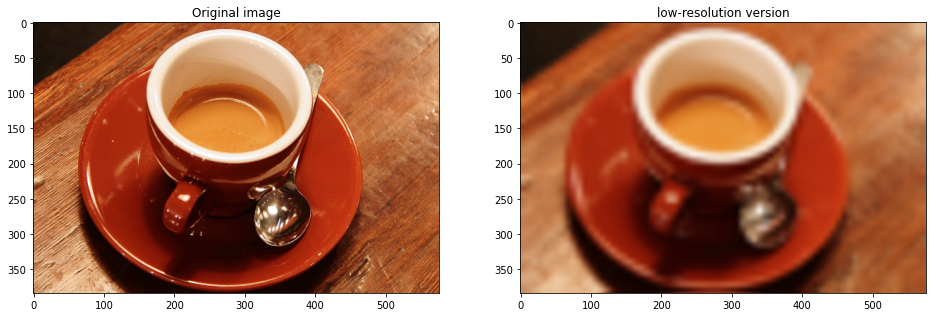

In [11]:
from skimage.transform import rescale
scale_factor = 8
img_lr = rescale(rescale(img, 1/scale_factor, order=3, anti_aliasing=True, multichannel=True),
                 scale_factor, order=3, multichannel=True)
show_sidebyside(img, img_lr, right_title='low-resolution version')

Let's run through the solution with this image as our guide then.

In [12]:
# store the original fit measure for later
D_orig = D
# compute fit using low-resolution version
D = compute_fit(pieces, img_lr)

%gams_push D
%gams solve puzzle using lp minimizing z;

Solver Status        Model Status  Objective  #equ    #var Model Type  \
0    Normal (1)  Optimal Global (1)     4.3861  1729  746497         LP   

  Solver Solver Time  
0  CPLEX       4.466

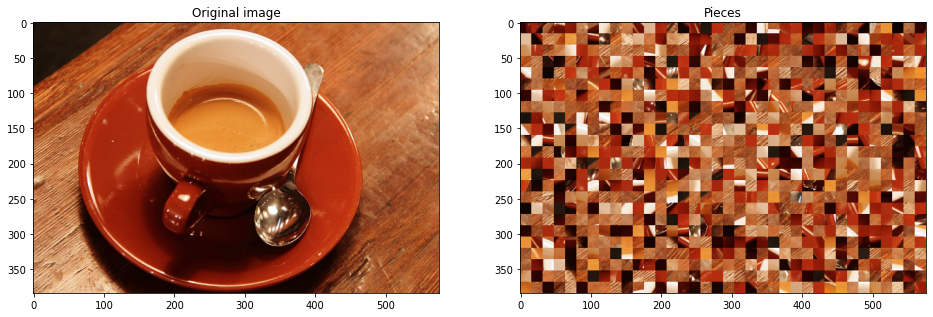

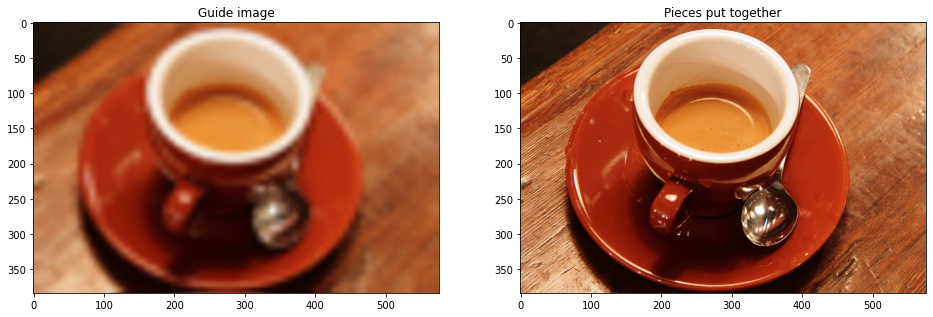

In [13]:
%gams_pull -d x
# only need the non-zero xs
x = x[x['level'] > 0]
# GAMS uses 1-indexing, Python uses 0-
# and we want ints now
x = x.iloc[:,:3].astype(int) - 1
sol = put_pieces_together(pieces, Hp, Wp, assign=x)
show_sidebyside(img, rect_layout(pieces, Hp, Wp), right_title='Pieces')
show_sidebyside(img_lr, sol, left_title='Guide image')

We can see that the solution is not perfect any more, though it is not too bad either! Only a couple of pieces are placed wrongly. Of course, if we were too aggressive with the undersampling for computing $D$ (choosing a higher value for `scale_factor` in the code above, such as 16), then things can get worse.

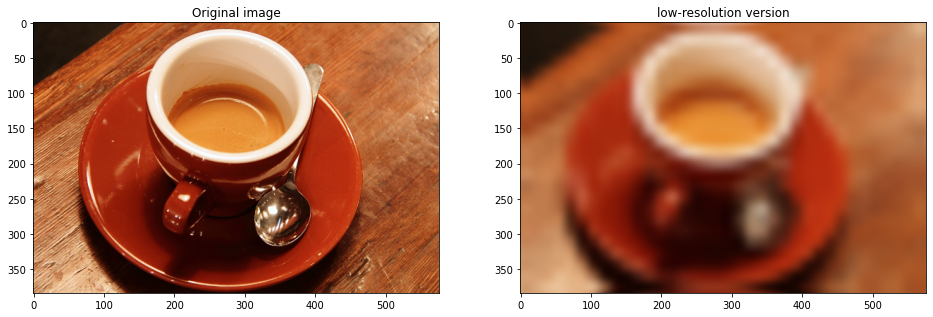

In [14]:
scale_factor = 16
img_lr = rescale(rescale(img, 1/scale_factor, order=3, anti_aliasing=True, multichannel=True),
                 scale_factor, order=3, multichannel=True)
show_sidebyside(img, img_lr, right_title='low-resolution version')

In [15]:
# compute fit using low-resolution version
D = compute_fit(pieces, img_lr)

%gams_push D
%gams solve puzzle using lp minimizing z;

Solver Status        Model Status  Objective  #equ    #var Model Type  \
0    Normal (1)  Optimal Global (1)     7.1761  1729  746497         LP   

  Solver Solver Time  
0  CPLEX       5.624

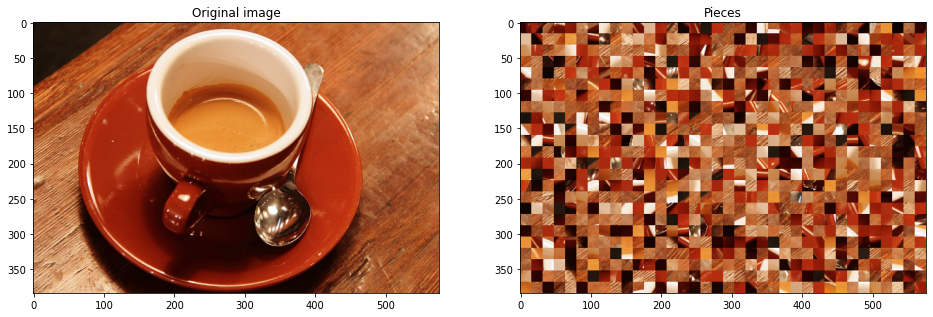

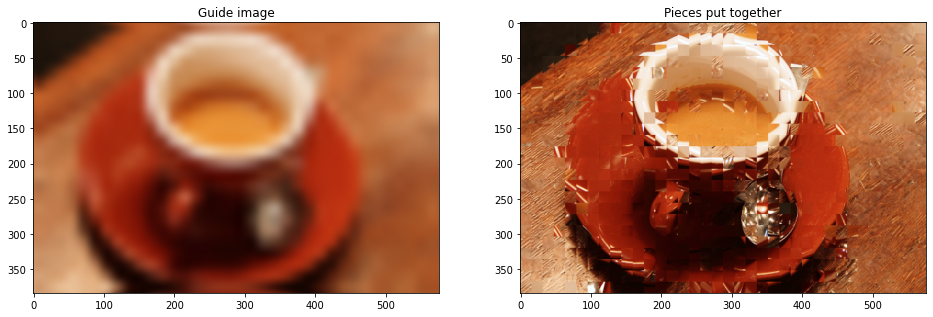

In [16]:
%gams_pull -d x
x = x[x['level'] > 0]
x = x.iloc[:,:3].astype(int) - 1
sol = put_pieces_together(pieces, Hp, Wp, assign=x)
show_sidebyside(img, rect_layout(pieces, Hp, Wp), right_title='Pieces')
show_sidebyside(img_lr, sol, left_title='Guide image')

The solution is not so great any more, though it'll not look too bad if you walk a few steps backwards and look at it from afar, so in a sense, we "solve" the puzzle up to the effective resolution of our guide image. 

This shows that the quality of the data (the guide image in this case) plays an important role in the solution process -- "*garbage in, garbage out*".

We can see that the problem becomes harder in this case as well: the solver takes more time to arrive at its solution compared to before. This probably has to do with the sharpness of the cost function landscape, which had a pointed minimum (zero cost at the correct piece location) when we had the exact ground truth image with us, but has many "reasonably close" points where we can place the piece when our information is not as good.

We can visualize this through the code below:

--------------------------------------------------------------------------------
Best candidates with full-resolution guide image


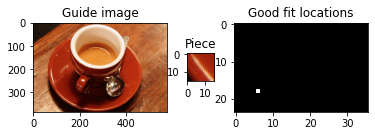

[(18, 6, 0.0),
 (0, 13, 0.0231214957388184),
 (12, 7, 0.023151812604126614),
 (12, 12, 0.023181108227604764),
 (11, 8, 0.02336901672433679),
 (7, 13, 0.02358049388055876),
 (14, 24, 0.02423679193899782),
 (13, 24, 0.024244541362296552),
 (6, 8, 0.024268530533128285),
 (8, 25, 0.024331567185697813)]
--------------------------------------------------------------------------------
Best candidates with low-resolution guide image


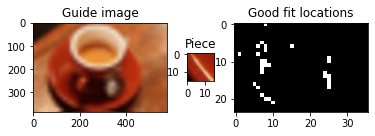

[(19, 7, 0.021302044680270544),
 (16, 5, 0.021603393792927014),
 (16, 25, 0.02212475388400094),
 (20, 8, 0.0223179455489044),
 (21, 10, 0.022799714723367285),
 (17, 25, 0.023104898867969088),
 (12, 7, 0.02341715122431835),
 (15, 25, 0.02354773785835958),
 (11, 8, 0.0236261628959633),
 (13, 7, 0.0237518206430961)]


In [17]:
# to show the cost function landscape for a specified piece
def show_piece_cost_landscape(img, pieces, D, piece_idx=None, thresh=0.01):
    if piece_idx is None:
        piece_idx = RNG.choice(D.shape[0])
    piece = pieces[piece_idx,:,:]
    psize = piece.shape[0]
    H, W = img.shape[:2]
    
    # Find points where the cost value is very low.
    # In the case with full-resolution ground truth, there should be 
    # only a unique point (the correct place), if we set the threshold
    # low enough.
    # But with approximate information there are no such guarantees.
    # The minimum-cost location could be wrong as well.
    candidates = D[piece_idx,:,:] < thresh
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                        gridspec_kw={'width_ratios': [1, 5*(psize/min(H,W)), 1]})
    ax1.imshow(img)
    ax1.set_title('Guide image')
    ax2.imshow(piece)
    ax2.set_title('Piece')
    im3 = ax3.imshow(candidates, cmap='gray')
    ax3.set_title('Good fit locations')
    plt.show()
    return

# show the top k candidate locations for a specified piece
from pprint import pprint as pp
def show_best_candidates(D, piece_idx=None, k=10):
    if piece_idx is None:
        piece_idx = RNG.choice(D.shape[0])
    cost = D[piece_idx,:,:]
    # take k min elements from D
    ind = np.unravel_index(np.argsort(cost, axis=None)[:k], cost.shape)
    pp(list(zip(ind[0], ind[1], cost.flatten()[np.ravel_multi_index(ind, cost.shape)])))
    
# choose any piece here, or leave None for random
piece_idx = 481

print('-'*80)
print('Best candidates with full-resolution guide image')
show_piece_cost_landscape(img, pieces, D_orig, piece_idx=piece_idx, thresh=0.02)
show_best_candidates(D_orig, piece_idx=piece_idx)

print('-'*80)
print('Best candidates with low-resolution guide image')
show_piece_cost_landscape(img_lr, pieces, D, piece_idx=piece_idx, thresh=0.025)
show_best_candidates(D, piece_idx=piece_idx)

We can see that the approximate information is throwing off our fit measure. Spurious locations become the best matches for some pieces such as the one above. To be sure, this doesn't happen for every piece (you can try different values of `piece_idx` in the code), but it happens for enough of them that the solution is not too great (as we saw earlier).

## Version 2: Enforcing continuity at piece edges

The previous result showed that the pieces are not very easy to put together if we can't get precise (and accurate) correspondences with the ground truth image. In the absence of this information, we will only get approximate answers such as the one above unless we have some other way of rejecting spurious solutions, which have optimal "fit" to our imperfect guide image, but are not realistic images themselves.

One obvious artifact in the solution above is that adjacent pieces do not match well at the boundaries, making the resulting solution image look blocky. We would like the image intensity to vary smoothly across pieces, such that the piece boundaries are not apparent (just like in the true image). Many image processing algorithms try to enforce/encourage this property in their output, through penalty functions based on image gradients.

We will try to use this idea of matching edges to choose the piece locations.

In [18]:
# We use very large pieces at first, to make sure the idea works in principle.
psize = 192
Hp, Wp = H // psize, W // psize
pieces = make_pieces_norotate(img, psize, shuffle=True)

# Hold the 4 edges of each piece separately
# Color images will be just laid out one after the other (flattened),
# since we compare pixels one-by-one.
E_top = np.array([pieces[n,0,:,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_bot = np.array([pieces[n,-1,:,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_left = np.array([pieces[n,:,0,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_right = np.array([pieces[n,:,-1,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)

In [19]:
# GAMS setup for new model
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

# remove cplex.opt file (optional); gams_cleanup doesn't remove it
import os
if os.path.exists('cplex.opt'):
    os.remove('cplex.opt')

In [20]:
%%gams
sets
    piece_idxs(*),
    row_idxs(*),
    col_idxs(*),
    edge_idxs(*);
parameters
    E_top(piece_idxs<, edge_idxs<),
    E_bot(piece_idxs<, edge_idxs<),
    E_left(piece_idxs<, edge_idxs<),
    E_right(piece_idxs<, edge_idxs<),
    row_idx_vals(row_idxs<),
    col_idx_vals(col_idxs<);

In [21]:
row_idx_vals = np.arange(1, Hp+1)
col_idx_vals = np.arange(1, Wp+1)
%gams_push E_top E_bot E_left E_right
%gams_push row_idx_vals col_idx_vals

Now let's set up the constraints to match edges. The constraints we defined earlier (`one_piece_one_place` and `one_place_one_piece`) remain the same, but our problem does not have the nice structure of before, so an LP solver doesn't give us an integral solution now (*I tried*).

Therefore, **we have to make our variables explicitly binary now, and use a MIP solver**.

In [22]:
%%gams
option mip = cplex;

alias (piece_idxs, P);
alias (row_idxs, I);
alias (col_idxs, J);
alias (edge_idxs, K);

binary variables
    xb(P,I,J);
free variables
    horiz_edge_diff(I,J,K),
    vert_edge_diff(I,J,K),
    horiz_edge_cost(I,J,K),
    vert_edge_cost(I,J,K),
    z;
equations
    one_piece_one_place_binary(P),
    one_place_one_piece_binary(I,J),
    eval_horiz_edge_diff(I,J,K),
    eval_vert_edge_diff(I,J,K),
    lim_horiz_edge_cost_pos(I,J,K),
    lim_horiz_edge_cost_neg(I,J,K),
    lim_vert_edge_cost_pos(I,J,K),
    lim_vert_edge_cost_neg(I,J,K),
    obj_eval_edgematch;

one_piece_one_place_binary(P)..
    sum((I,J), xb(P,I,J)) =e= 1;

one_place_one_piece_binary(I,J)..
    sum(P, xb(P,I,J)) =e= 1;

eval_horiz_edge_diff(I,J,K)$(ord(J) lt card(J))..
    horiz_edge_diff(I,J,K) =e= sum(P, xb(P,I,J+1) * E_left(P,K)) - sum(P, xb(P,I,J) * E_right(P,K));

eval_vert_edge_diff(I,J,K)$(ord(I) lt card(I))..
    vert_edge_diff(I,J,K) =e= sum(P, xb(P,I+1,J) * E_top(P,K)) - sum(P, xb(P,I,J) * E_bot(P,K));

lim_horiz_edge_cost_pos(I,J,K)..
    horiz_edge_cost(I,J,K) =g= horiz_edge_diff(I,J,K);
    
lim_horiz_edge_cost_neg(I,J,K)..
    horiz_edge_cost(I,J,K) =g= -horiz_edge_diff(I,J,K);
    
lim_vert_edge_cost_pos(I,J,K)..
    vert_edge_cost(I,J,K) =g= vert_edge_diff(I,J,K);
    
lim_vert_edge_cost_neg(I,J,K)..
    vert_edge_cost(I,J,K) =g= -vert_edge_diff(I,J,K);
    
horiz_edge_cost.lo(I,J,K) = 0;
vert_edge_cost.lo(I,J,K) = 0;
horiz_edge_diff.fx(I,J,K)$(ord(J) eq card(J)) = 0;
vert_edge_diff.fx(I,J,K)$(ord(I) eq card(I)) = 0;

obj_eval_edgematch..
    z =e= sum((I,J,K), horiz_edge_cost(I,J,K) + vert_edge_cost(I,J,K));

model puzzle_edgematch
    /
        one_piece_one_place_binary,
        one_place_one_piece_binary,
        eval_horiz_edge_diff,
        eval_vert_edge_diff,
        lim_horiz_edge_cost_pos,
        lim_horiz_edge_cost_neg,
        lim_vert_edge_cost_pos,
        lim_vert_edge_cost_neg,
        obj_eval_edgematch
    /;

In [23]:
%gams solve puzzle_edgematch using mip minimizing z;

Solver Status        Model Status  Objective   #equ   #var Model Type  \
0    Normal (1)  Optimal Global (1)   122.7176  17869  13861        MIP   

  Solver Solver Time  
0  CPLEX       4.672

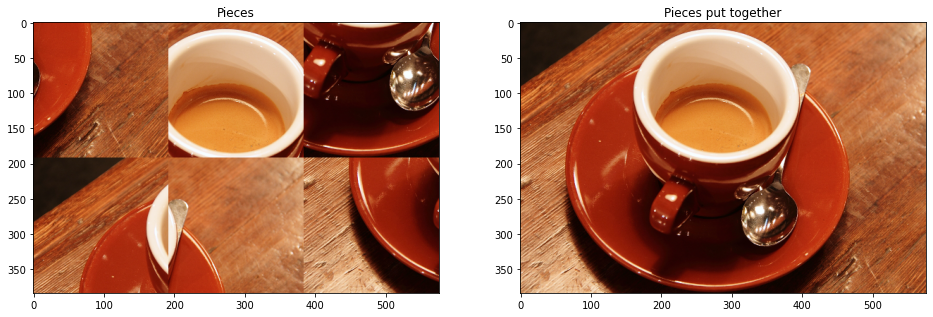

In [24]:
%gams_pull -d xb
xb = xb[xb['level'] > 0]
xb = xb.iloc[:,:3].astype(int) - 1
sol = put_pieces_together(pieces, Hp, Wp, assign=xb)
show_sidebyside(rect_layout(pieces, Hp, Wp), sol, left_title='Pieces', right_title='Pieces put together')

We get the right solution for this case, but there is no guarantee any more that the result will always be right, since we have just used a heuristic.

Let's try a harder problem with more pieces?

In [25]:
# for some reason I have to reset GAMS for this to work
%gams_reset
%gams_cleanup -k

In [26]:
%%gams
sets
    piece_idxs(*),
    row_idxs(*),
    col_idxs(*),
    edge_idxs(*);
parameters
    E_top(piece_idxs<, edge_idxs<),
    E_bot(piece_idxs<, edge_idxs<),
    E_left(piece_idxs<, edge_idxs<),
    E_right(piece_idxs<, edge_idxs<),
    row_idx_vals(row_idxs<),
    col_idx_vals(col_idxs<);

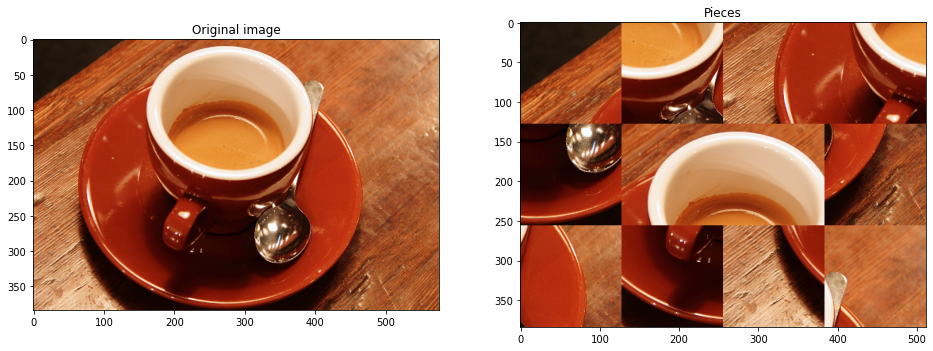

In [27]:
# Small step up: going from 2x3 to 3x4
psize = 128
Hp, Wp = H // psize, W // psize
pieces = make_pieces_norotate(img, psize, shuffle=True)
show_sidebyside(img, rect_layout(pieces, Hp, Wp), right_title='Pieces')

# Hold the 4 edges of each piece separately
# Color images will be just laid out one after the other (flattened),
# since we compare pixels one-by-one. lt 
E_top = np.array([pieces[n,0,:,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_bot = np.array([pieces[n,-1,:,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_left = np.array([pieces[n,:,0,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_right = np.array([pieces[n,:,-1,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)

row_idx_vals = np.arange(1, Hp+1)
col_idx_vals = np.arange(1, Wp+1)
%gams_push E_top E_bot E_left E_right
%gams_push row_idx_vals col_idx_vals

In [28]:
%%gams
option mip = cplex;

alias (piece_idxs, P);
alias (row_idxs, I);
alias (col_idxs, J);
alias (edge_idxs, K);

binary variables
    xb(P,I,J);
free variables
    horiz_edge_diff(I,J,K),
    vert_edge_diff(I,J,K),
    horiz_edge_cost(I,J,K),
    vert_edge_cost(I,J,K),
    z;
equations
    one_piece_one_place_binary(P),
    one_place_one_piece_binary(I,J),
    eval_horiz_edge_diff(I,J,K),
    eval_vert_edge_diff(I,J,K),
    lim_horiz_edge_cost_pos(I,J,K),
    lim_horiz_edge_cost_neg(I,J,K),
    lim_vert_edge_cost_pos(I,J,K),
    lim_vert_edge_cost_neg(I,J,K),
    obj_eval_edgematch;

one_piece_one_place_binary(P)..
    sum((I,J), xb(P,I,J)) =e= 1;

one_place_one_piece_binary(I,J)..
    sum(P, xb(P,I,J)) =e= 1;

eval_horiz_edge_diff(I,J,K)$(ord(J) lt card(J))..
    horiz_edge_diff(I,J,K) =e= sum(P, xb(P,I,J+1) * E_left(P,K)) - sum(P, xb(P,I,J) * E_right(P,K));

eval_vert_edge_diff(I,J,K)$(ord(I) lt card(I))..
    vert_edge_diff(I,J,K) =e= sum(P, xb(P,I+1,J) * E_top(P,K)) - sum(P, xb(P,I,J) * E_bot(P,K));

lim_horiz_edge_cost_pos(I,J,K)..
    horiz_edge_cost(I,J,K) =g= horiz_edge_diff(I,J,K);
    
lim_horiz_edge_cost_neg(I,J,K)..
    horiz_edge_cost(I,J,K) =g= -horiz_edge_diff(I,J,K);
    
lim_vert_edge_cost_pos(I,J,K)..
    vert_edge_cost(I,J,K) =g= vert_edge_diff(I,J,K);
    
lim_vert_edge_cost_neg(I,J,K)..
    vert_edge_cost(I,J,K) =g= -vert_edge_diff(I,J,K);
    
horiz_edge_cost.lo(I,J,K) = 0;
vert_edge_cost.lo(I,J,K) = 0;
horiz_edge_diff.fx(I,J,K)$(ord(J) eq card(J)) = 0;
vert_edge_diff.fx(I,J,K)$(ord(I) eq card(I)) = 0;

obj_eval_edgematch..
    z =e= sum((I,J,K), horiz_edge_cost(I,J,K) + vert_edge_cost(I,J,K));

model puzzle_edgematch
    /
        one_piece_one_place_binary,
        one_place_one_piece_binary,
        eval_horiz_edge_diff,
        eval_vert_edge_diff,
        lim_horiz_edge_cost_pos,
        lim_horiz_edge_cost_neg,
        lim_vert_edge_cost_pos,
        lim_vert_edge_cost_neg,
        obj_eval_edgematch
    /;

In [29]:
# this can take a long time (> 3 mins)
%gams solve puzzle_edgematch using mip minimizing z;

Solver Status        Model Status  Objective   #equ   #var Model Type  \
0    Normal (1)  Optimal Global (1)    147.302  24985  18577        MIP   

  Solver Solver Time  
0  CPLEX     139.043

That was a long time, wasn't it? This formulation rapidly becomes impossibly slow. I'm not completely sure why that is, but it does make intuitive sense that having just pairwise relations between pieces (through the edge cost measure) gives us a lot of work to do, compared to a direct signal towards where a piece should go, as we get from $D(p,i,j)$.

Anyway, is our solution good for this case at least?

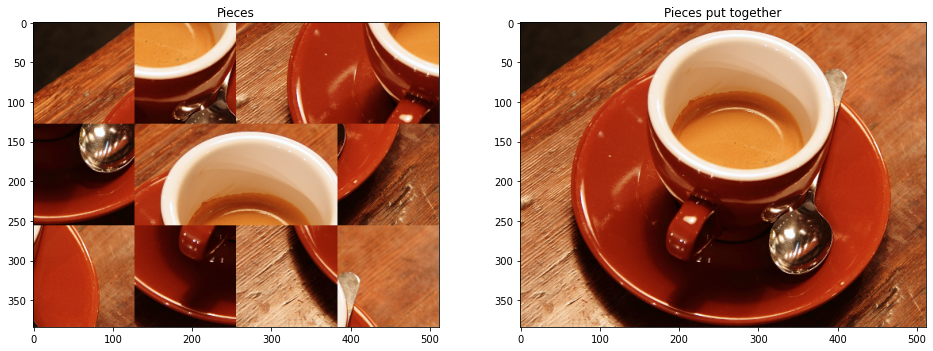

In [30]:
%gams_pull -d xb
xb = xb[xb['level'] > 0]
xb = xb.iloc[:,:3].astype(int) - 1
sol = put_pieces_together(pieces, Hp, Wp, assign=xb)
show_sidebyside(rect_layout(pieces, Hp, Wp), sol, left_title='Pieces', right_title='Pieces put together')

That's a relief. But we can't expect to extend this idea to the kinds of piece sizes we saw with the guide image. It'll take too long.

## Version 3: merging the two approaches

We can see from the previous experiments that we can easily put together the pieces if we have a good guide image. Also, we saw that the pieces are hard to put together if the guide image is of bad quality (blocky results), or not present at all (the alternate model is very slow to solve).

We can try combining the good parts of both methods to get a better result than either one individually, in the case where we have an approximate (very low-resolution) guide image. The method based only on the computed fit measure $D(p,i,j)$ gives a partial solution, but its pieces don't match up well with their adjacent neighbors. The second method based on matching edge pixel values does better in that regard, so a simple idea is to use the output of the method with the guide image as the initialization to the second method. The hope is that this gives a reasonably good and feasible solution to the branch-and-bound solver, which could help it narrow down the search space faster. We show this through the code below: 

In [31]:
# reset GAMS
%gams_reset
%gams_cleanup -k
# remove cplex.opt file (optional); gams_cleanup doesn't remove it
import os
if os.path.exists('cplex.opt'):
    os.remove('cplex.opt')

In [32]:
%%gams
sets
    piece_idxs(*),
    row_idxs(*),
    col_idxs(*),
    edge_idxs(*);
parameters
    D(piece_idxs<, row_idxs<, col_idxs<),
    E_top(piece_idxs<, edge_idxs<),
    E_bot(piece_idxs<, edge_idxs<),
    E_left(piece_idxs<, edge_idxs<),
    E_right(piece_idxs<, edge_idxs<);

In [33]:
# try the same size as before
psize = 128
Hp, Wp = H // psize, W // psize
pieces = make_pieces_norotate(img, psize, shuffle=True)

scale_factor = 16
img_lr = rescale(rescale(img, 1/scale_factor, order=3, anti_aliasing=True, multichannel=True),
                 scale_factor, order=3, multichannel=True)
# compute fit with respect to low-resolution guide image
D = compute_fit(pieces, img_lr)

# Hold the 4 edges of each piece separately
# Color images will be just laid out one after the other (flattened),
# since we compare pixels one-by-one.
E_top = np.array([pieces[n,0,:,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_bot = np.array([pieces[n,-1,:,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_left = np.array([pieces[n,:,0,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)
E_right = np.array([pieces[n,:,-1,...].flatten() for n in range(Hp*Wp)], dtype=pieces.dtype)

%gams_push D E_top E_bot E_left E_right

In [34]:
%%gams
option lp = cplex;
option mip = cplex;
option threads = 4;
$onecho > cplex.opt
lpmethod 3
$offecho

alias (piece_idxs, P);
alias (row_idxs, I);
alias (col_idxs, J);
alias (edge_idxs, K);

free variables
    x0(P,I,J),
    z;
    
equations
    one_piece_one_place(P),
    one_place_one_piece(I,J),
    obj_eval_D;
    
one_piece_one_place(P)..
    sum((I,J), x0(P,I,J)) =e= 1;

one_place_one_piece(I,J)..
    sum(P, x0(P,I,J)) =e= 1;

obj_eval_D..
    z =e= sum((P,I,J), x0(P,I,J) * D(P,I,J));

x0.lo(P,I,J) = 0;
model puzzle_D
    /
        one_piece_one_place,
        one_place_one_piece,
        obj_eval_D
    /;

binary variables
    xb(P,I,J);
free variables
    horiz_edge_diff(I,J,K),
    vert_edge_diff(I,J,K),
    horiz_edge_cost(I,J,K),
    vert_edge_cost(I,J,K);
equations
    one_piece_one_place_binary(P),
    one_place_one_piece_binary(I,J),
    eval_horiz_edge_diff(I,J,K),
    eval_vert_edge_diff(I,J,K),
    lim_horiz_edge_cost_pos(I,J,K),
    lim_horiz_edge_cost_neg(I,J,K),
    lim_vert_edge_cost_pos(I,J,K),
    lim_vert_edge_cost_neg(I,J,K),
    obj_eval_edgematch;

one_piece_one_place_binary(P)..
    sum((I,J), xb(P,I,J)) =e= 1;

one_place_one_piece_binary(I,J)..
    sum(P, xb(P,I,J)) =e= 1;

eval_horiz_edge_diff(I,J,K)$(ord(J) lt card(J))..
    horiz_edge_diff(I,J,K) =e= sum(P, xb(P,I,J+1) * E_left(P,K)) - sum(P, xb(P,I,J) * E_right(P,K));

eval_vert_edge_diff(I,J,K)$(ord(I) lt card(I))..
    vert_edge_diff(I,J,K) =e= sum(P, xb(P,I+1,J) * E_top(P,K)) - sum(P, xb(P,I,J) * E_bot(P,K));

lim_horiz_edge_cost_pos(I,J,K)..
    horiz_edge_cost(I,J,K) =g= horiz_edge_diff(I,J,K);
    
lim_horiz_edge_cost_neg(I,J,K)..
    horiz_edge_cost(I,J,K) =g= -horiz_edge_diff(I,J,K);
    
lim_vert_edge_cost_pos(I,J,K)..
    vert_edge_cost(I,J,K) =g= vert_edge_diff(I,J,K);
    
lim_vert_edge_cost_neg(I,J,K)..
    vert_edge_cost(I,J,K) =g= -vert_edge_diff(I,J,K);
    
horiz_edge_cost.lo(I,J,K) = 0;
vert_edge_cost.lo(I,J,K) = 0;
horiz_edge_diff.fx(I,J,K)$(ord(J) eq card(J)) = 0;
vert_edge_diff.fx(I,J,K)$(ord(I) eq card(I)) = 0;

obj_eval_edgematch..
    z =e= sum((I,J,K), horiz_edge_cost(I,J,K) + vert_edge_cost(I,J,K));

model puzzle_edgematch
    /
        one_piece_one_place_binary,
        one_place_one_piece_binary,
        eval_horiz_edge_diff,
        eval_vert_edge_diff,
        lim_horiz_edge_cost_pos,
        lim_horiz_edge_cost_neg,
        lim_vert_edge_cost_pos,
        lim_vert_edge_cost_neg,
        obj_eval_edgematch
    /;


solve puzzle_D using lp minimizing z;

* initialize binary variables with this solution
xb.l(P,I,J)$(x0.l(P,I,J) > EPS) = 1;

solve puzzle_edgematch using mip minimizing z;

Solver Status        Model Status  Objective   #equ   #var Model Type  \
0    Normal (1)  Optimal Global (1)     0.1275     25    145         LP   
1    Normal (1)  Optimal Global (1)   147.3020  24985  18577        MIP   

  Solver Solver Time  
0  CPLEX       0.023  
1  CPLEX       104.3

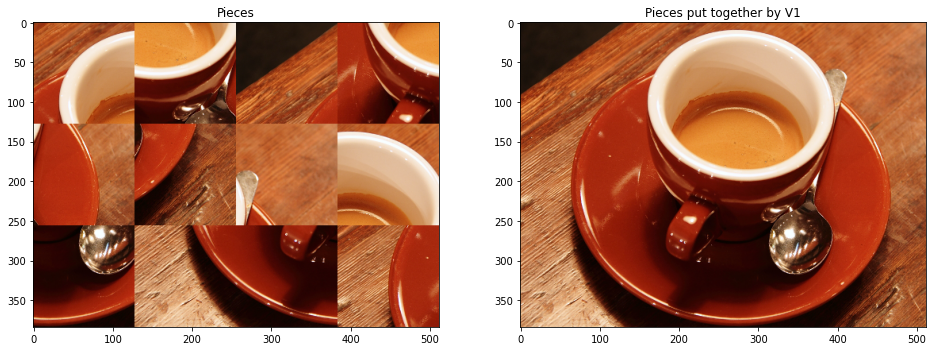

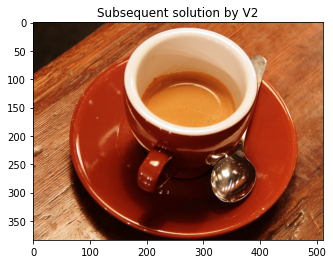

In [35]:
%gams_pull -d x0 xb

x0 = x0[x0['level'] > 0]
x0 = x0.iloc[:,:3].astype(int) - 1
sol0 = put_pieces_together(pieces, Hp, Wp, assign=x0)
show_sidebyside(rect_layout(pieces, Hp, Wp), sol0, left_title='Pieces', right_title='Pieces put together by V1')

xb = xb[xb['level'] > 0]
xb = xb.iloc[:,:3].astype(int) - 1
sol = put_pieces_together(pieces, Hp, Wp, assign=xb)
plt.imshow(sol)
plt.title('Subsequent solution by V2')
plt.show()

We see that the solver works a little bit faster this time with the better initialization, but it's still quite slow. It doesn't look like we can run this idea with the small piece sizes we saw earlier.

The next idea is to make the `edgematch` model more restricted, such that pieces can only move a little distance from the initialization (within a $3 \times 3$ neighborhood, say). This drastically reduces the space of possible solutions for the second phase, but it remains to be seen whether this change makes the model tractable for small piece sizes. Unfortunately, I have not been able to get to this by the deadline.

## Conclusion

We have seen two possible ways to formulate a kind-of-jigsaw-puzzle solver. The first one assumes the presence of a guide image to inform the solver about which locations are suitable for every piece, while the second one works without any additional data and just enforces consistency across piece boundaries. The simple structure of the first model allows solution through even an LP solver, but we need a MIP solver for the second method.

This problem probably doesn't have any real-world applications or context, so it is up to the modeler's wishes whether the guide image is available to them or not. From the above experiments, it would appear that they should definitely try to get a hold of some guiding information like we used here, to help direct the solution process.

### Possible extensions

- As said previously, using the guide image to provide an initialization to the piece edge-matching method. Limiting the edge-matching method to only move pieces within a small neighborhood of the initialization to reduce the search space.
- Allowing pieces to be rotated. This is quite straightforward to implement, but it doesn't add any particularly interesting conceptual difficulty for modeling, and makes all the solution methods slower (and less reliable...).
- Incorporating shape information in pieces, to move beyond square puzzle pieces to real jigsaw pieces. This is somewhat complicated to encode, but it would help the solver by reducing the solution space.